In [ ]:
!pip install pingouin
!pip install datasist
!pip install category_encoders

In [ ]:
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
sns.set_palette('rocket')
from time import time
import pingouin
from scipy.stats import ttest_ind
from datasist.structdata import detect_outliers
from geopy.distance import great_circle
from category_encoders import WOEEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv("Data/fraudTrain.csv")
test = pd.read_csv("Data/fraudTest.csv")
train = train.drop(train.columns[0], axis=1)
test = test.drop(test.columns[0],axis=1)
train

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [ ]:
train['split'] = 'train'
test['split']='test'
df = pd.concat([train,test],axis=0).reset_index(drop=True)
df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,split
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,train
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,train
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,train
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,train
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,test
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,test
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,test
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,test


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
 22  split             

In [ ]:
#Check Nulls
df.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
split                    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
#Drop unnecessary columns
#We will drop lcoation of customer as we will get the distance between
#Merchant and customer location later
df.drop(columns=['street','state','first','last','trans_num','unix_time'],inplace=True)

In [ ]:
#Extract features from 'trans_date_trans_time'
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['month'] = df['trans_date_trans_time'].dt.month


In [ ]:
#Date of birth --> Age of customer
df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d %H:%M:%S')
df['age'] = (df['trans_date_trans_time'].dt.year - df['dob'].dt.year).astype(int)
df.drop(columns='dob',inplace=True)

In [ ]:
#Location between customer home and merchant
df['distance_km'] = df.apply(lambda col : round(great_circle((col['lat'],col['long']),
                                         (col['merch_lat'],col['merch_long'])).kilometers,2),axis=1)

In [ ]:
#Drop the proccesed columns
df.drop(columns=['lat','long','merch_lat','merch_long'],inplace=True)


In [ ]:
#clean merchant column
df['merchant'] = df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [ ]:
#Convert gender to binary classification
df['gender'].replace({'M': 1, 'F': 0}, inplace=True)


In [ ]:
df

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,is_fraud,split,hour,day_of_week,month,age,distance_km
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,0,Moravian Falls,28654,3495,"Psychologist, counselling",0,train,0,1,1,31,78.60
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,0,Orient,99160,149,Special educational needs teacher,0,train,0,1,1,41,30.21
2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,1,Malad City,83252,4154,Nature conservation officer,0,train,0,1,1,57,108.21
3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,1,Boulder,59632,1939,Patent attorney,0,train,0,1,1,52,95.67
4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,1,Doe Hill,24433,99,Dance movement psychotherapist,0,train,0,1,1,33,77.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,Reilly and Sons,health_fitness,43.77,1,Luray,63453,519,Town planner,0,test,23,3,12,54,77.03
1852390,2020-12-31 23:59:09,3556613125071656,Hoppe-Parisian,kids_pets,111.84,1,Lake Jackson,77566,28739,Futures trader,0,test,23,3,12,21,100.07
1852391,2020-12-31 23:59:15,6011724471098086,Rau-Robel,kids_pets,86.88,0,Burbank,99323,3684,Musician,0,test,23,3,12,39,80.76
1852392,2020-12-31 23:59:24,4079773899158,Breitenberg LLC,travel,7.99,1,Mesa,83643,129,Cartographer,0,test,23,3,12,55,52.93


In [ ]:
#We will get the time between transactions for each card
#Time=0 for every first transaction and time will be represented in hours.
df.sort_values(['cc_num', 'trans_date_trans_time'],inplace=True)
df['hours_diff_bet_trans']=((df.groupby('cc_num')[['trans_date_trans_time']].diff())/np.timedelta64(1,'h'))

In [ ]:
df.loc[df['hours_diff_bet_trans'].isna(),'hours_diff_bet_trans'] = 0
df['hours_diff_bet_trans'] = df['hours_diff_bet_trans'].astype(int)

In [ ]:
df

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,is_fraud,split,hour,day_of_week,month,age,distance_km,hours_diff_bet_trans
1017,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,0,Fort Washakie,82514,1645,Information systems manager,0,train,12,1,1,33,127.61,0
2724,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,0,Fort Washakie,82514,1645,Information systems manager,0,train,8,2,1,33,110.31,19
2726,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,0,Fort Washakie,82514,1645,Information systems manager,0,train,8,2,1,33,21.79,0
2882,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,0,Fort Washakie,82514,1645,Information systems manager,0,train,12,2,1,33,87.20,3
2907,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,0,Fort Washakie,82514,1645,Information systems manager,0,train,13,2,1,33,74.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849259,2020-12-31 02:10:10,4992346398065154184,Parisian and Sons,gas_transport,66.11,1,Mc Nabb,61335,532,Audiological scientist,0,test,2,3,12,64,44.89,2
1849567,2020-12-31 05:13:35,4992346398065154184,Bogisich-Homenick,misc_net,4.58,1,Mc Nabb,61335,532,Audiological scientist,0,test,5,3,12,64,81.49,3
1850234,2020-12-31 11:15:44,4992346398065154184,Erdman-Kertzmann,gas_transport,95.96,1,Mc Nabb,61335,532,Audiological scientist,0,test,11,3,12,64,36.05,6
1850235,2020-12-31 11:17:25,4992346398065154184,Stracke-Lemke,grocery_pos,149.48,1,Mc Nabb,61335,532,Audiological scientist,0,test,11,3,12,64,81.77,0


                T          p-val
T-test  27.266899  7.200860e-158


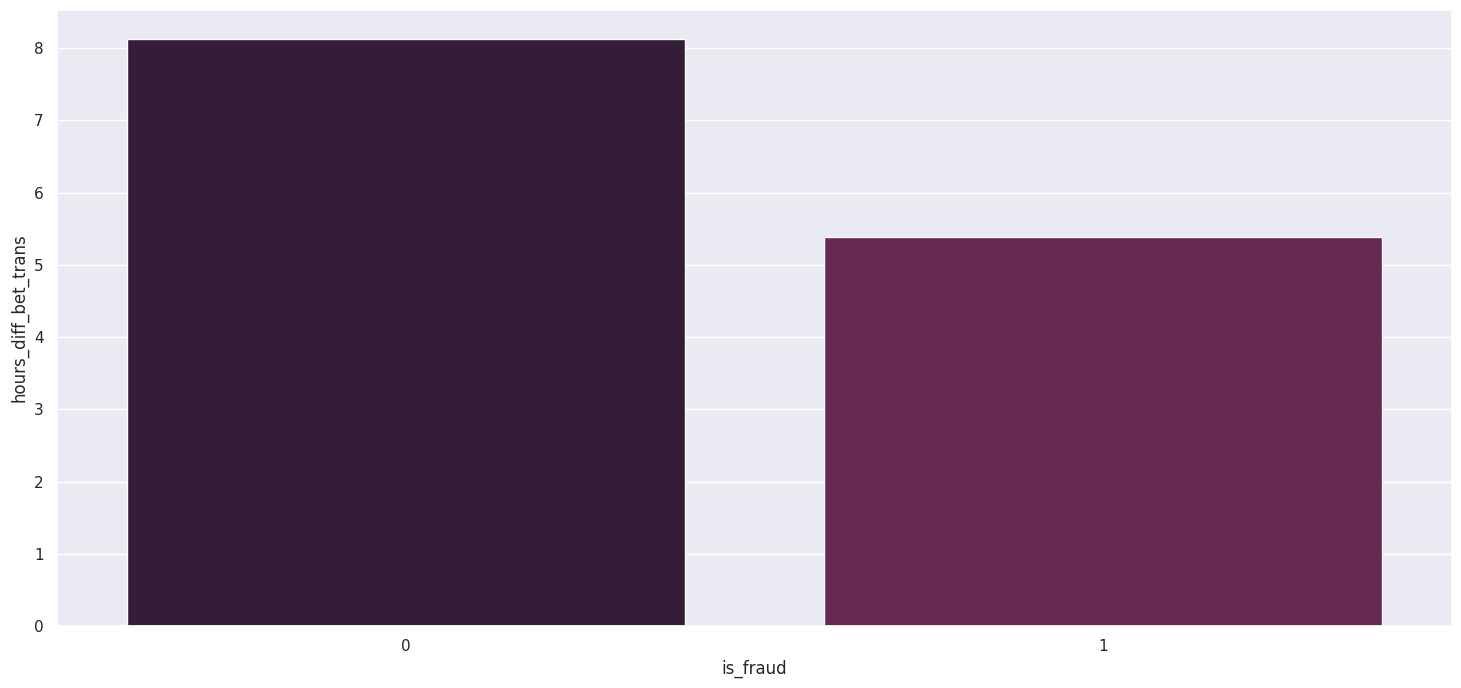

In [ ]:
# x_0=df.groupby('is_fraud')['hours_diff_bet_trans'].mean().values[0]
# x_1=df.groupby('is_fraud')['hours_diff_bet_trans'].mean().values[1]
# std_0=df.groupby('is_fraud')['hours_diff_bet_trans'].std().values[0]
# std_1=df.groupby('is_fraud')['hours_diff_bet_trans'].std().values[1]
# n_0=df.groupby('is_fraud')['hours_diff_bet_trans'].count().values[0]
# n_1=df.groupby('is_fraud')['hours_diff_bet_trans'].count().values[1]
# numerator = x_0 - x_1
# domin = np.sqrt(std_0**2/n_0 + std_1**2/n_1)
# t_stat=numerator/domin
# p_val = 2*(1-t.cdf(abs(t_stat),df=n_0+n_1-2))
# print(t_stat,p_val)
#----------------------
#The power of pingouin library!
print(pingouin.ttest(df[df['is_fraud'] == 0]['hours_diff_bet_trans'],
              df[df['is_fraud'] == 1]['hours_diff_bet_trans'],
              alternative='two-sided')[['T','p-val']])
sns.barplot(data=df,x='is_fraud',y='hours_diff_bet_trans',ci=None)
plt.show()

In [ ]:
#Handling and extracting features from cc_num
freq = df.groupby('cc_num').size()
df['cc_freq'] = df['cc_num'].apply(lambda x : freq[x])

In [ ]:
df

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,is_fraud,split,hour,day_of_week,month,age,distance_km,hours_diff_bet_trans,cc_freq
1017,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,0,Fort Washakie,82514,1645,Information systems manager,0,train,12,1,1,33,127.61,0,2196
2724,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,0,Fort Washakie,82514,1645,Information systems manager,0,train,8,2,1,33,110.31,19,2196
2726,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,0,Fort Washakie,82514,1645,Information systems manager,0,train,8,2,1,33,21.79,0,2196
2882,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,0,Fort Washakie,82514,1645,Information systems manager,0,train,12,2,1,33,87.20,3,2196
2907,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,0,Fort Washakie,82514,1645,Information systems manager,0,train,13,2,1,33,74.21,0,2196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849259,2020-12-31 02:10:10,4992346398065154184,Parisian and Sons,gas_transport,66.11,1,Mc Nabb,61335,532,Audiological scientist,0,test,2,3,12,64,44.89,2,2922
1849567,2020-12-31 05:13:35,4992346398065154184,Bogisich-Homenick,misc_net,4.58,1,Mc Nabb,61335,532,Audiological scientist,0,test,5,3,12,64,81.49,3,2922
1850234,2020-12-31 11:15:44,4992346398065154184,Erdman-Kertzmann,gas_transport,95.96,1,Mc Nabb,61335,532,Audiological scientist,0,test,11,3,12,64,36.05,6,2922
1850235,2020-12-31 11:17:25,4992346398065154184,Stracke-Lemke,grocery_pos,149.48,1,Mc Nabb,61335,532,Audiological scientist,0,test,11,3,12,64,81.77,0,2922


In [ ]:
#We got freq for each cc_num
def hist_show(col):
    fig,axs = plt.subplots(1,2,sharex=True)
    for i in [0,1]:
        sns.histplot(df[df["is_fraud"]==i][col], bins=6,ax=axs[i])

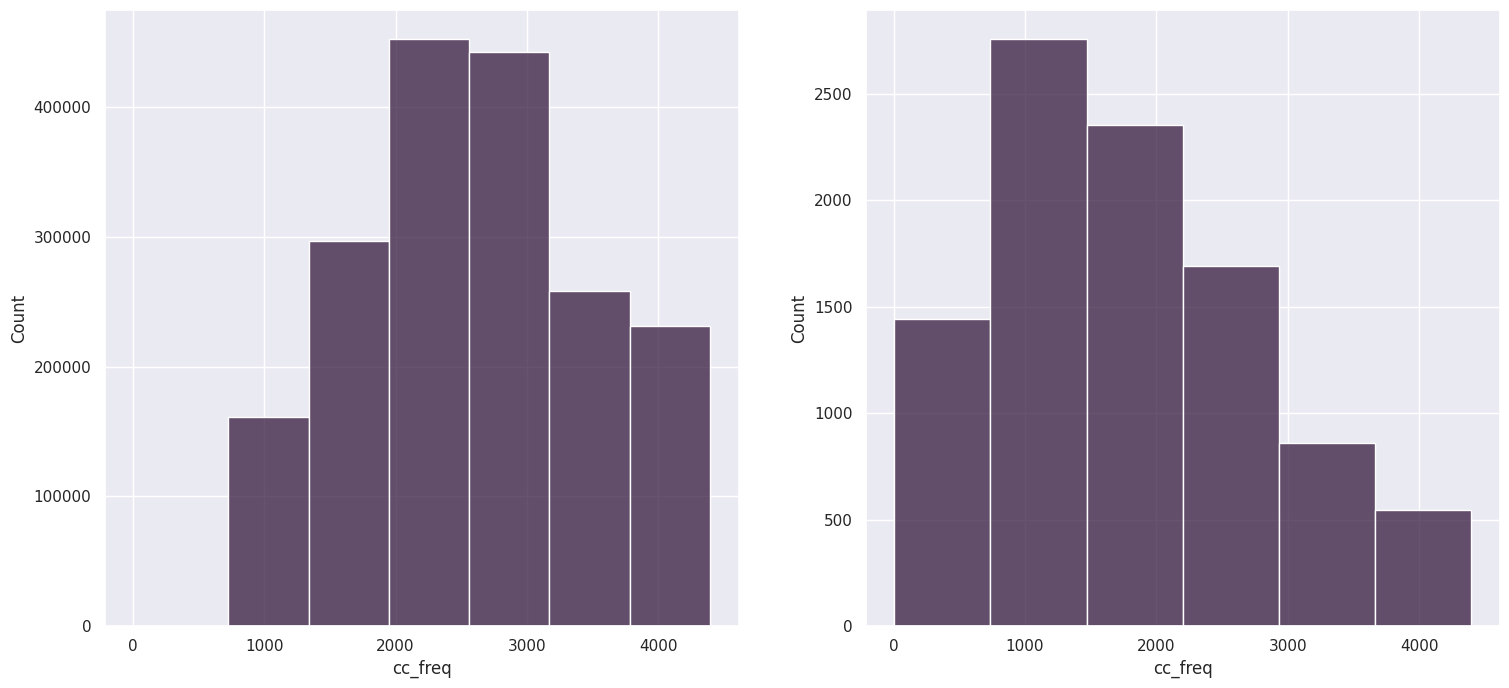

In [ ]:
hist_show('cc_freq')

In [ ]:
def class_det(x):
    for idx,val in enumerate(list(range(800,5000,800))):
        if x < val:
            return idx+1

In [ ]:
df['cc_freq_class'] = df['cc_freq'].apply(class_det)
print(df['cc_freq_class'].unique())

[3 1 2 4 5 6]


In [ ]:
#Drop unecessary columns
df.drop(columns=['cc_num','trans_date_trans_time','city_pop'],inplace=True)

In [ ]:
#Reorder columns
df = df[['cc_freq','cc_freq_class','city','job','age','gender','merchant', 'category',
         'distance_km','month','day_of_week','hour','hours_diff_bet_trans','amt','is_fraud','split']]

In [ ]:
#We will encode ('city','job','merchant', 'category') preparing for our model using WOE encoder
# WOE > 0: The category is more likely associated with (fraud)
# WOE < 0: The category is more likely associated with (non-fraud)
for col in ['city','job','merchant', 'category']:
    df[col] = WOEEncoder().fit_transform(df[col],df['is_fraud'])

In [ ]:
df

,cc_freq,cc_freq_class,city,job,age,gender,merchant,category,distance_km,month,day_of_week,hour,hours_diff_bet_trans,amt,is_fraud,split
1017,2196,3,-0.193426,0.163804,33,0,0.472059,0.925860,127.61,1,1,12,0,7.27,0,train
2724,2196,3,-0.193426,0.163804,33,0,-0.499771,-0.238221,110.31,1,2,8,19,52.94,0,train
2726,2196,3,-0.193426,0.163804,33,0,-0.132212,-0.238221,21.79,1,2,8,0,82.08,0,train
2882,2196,3,-0.193426,0.163804,33,0,-0.620062,-1.019735,87.20,1,2,12,3,34.79,0,train
2907,2196,3,-0.193426,0.163804,33,0,-1.296190,-1.238421,74.21,1,2,13,0,27.18,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849259,2922,4,-0.528658,0.253157,64,1,0.301146,-0.238221,44.89,12,3,2,2,66.11,0,test
1849567,2922,4,-0.528658,0.253157,64,1,1.088405,0.925860,81.49,12,3,5,3,4.58,0,test
1850234,2922,4,-0.528658,0.253157,64,1,-0.164096,-0.238221,36.05,12,3,11,6,95.96,0,test
1850235,2922,4,-0.528658,0.253157,64,1,1.013009,0.894448,81.77,12,3,11,0,149.48,0,test


In [ ]:
x_train = df[df['split']=='train'].drop(['split','is_fraud'],axis=1)
y_train = df[df['split']=='train']['is_fraud']
x_test = df[df['split']=='test'].drop(['split','is_fraud'],axis=1)
y_test = df[df['split']=='test']['is_fraud']

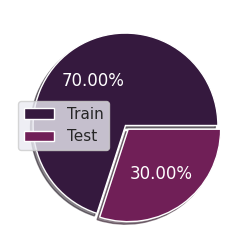

In [ ]:
plt.figure(figsize=(3,3))
plt.pie([len(x_train),len(x_test)],autopct='%.2f%%'
        ,textprops={'color':'white'},explode=[0,0.05],shadow=True)
plt.legend(['Train','Test'])
plt.show()

In [ ]:
#Handling outliers
x_train.select_dtypes(include='number').columns
datasets={'x_train':x_train,'x_test':x_test}
cols = ['hours_diff_bet_trans', 'amt']

#Outliers in train data before scaling
def count_outliers(l:list):
    for col in l:
        print(f'Outliers In {col}:',len(detect_outliers(x_train,0,[col])))

def boxplot_outliers(ds:dict):
    plt.figure(figsize=(18,8))
    c=1
    for _,df_x in ds.items():
        for col in ['hours_diff_bet_trans', 'amt']:
            plt.subplot(2,2,c)
            df_x[col].plot(kind='box',vert=False)
            c+=1
    plt.suptitle('Detecting Outliers In Train|Test Data',fontsize=20)
    plt.tight_layout()


Outliers In hours_diff_bet_trans: 86989
Outliers In amt: 67290


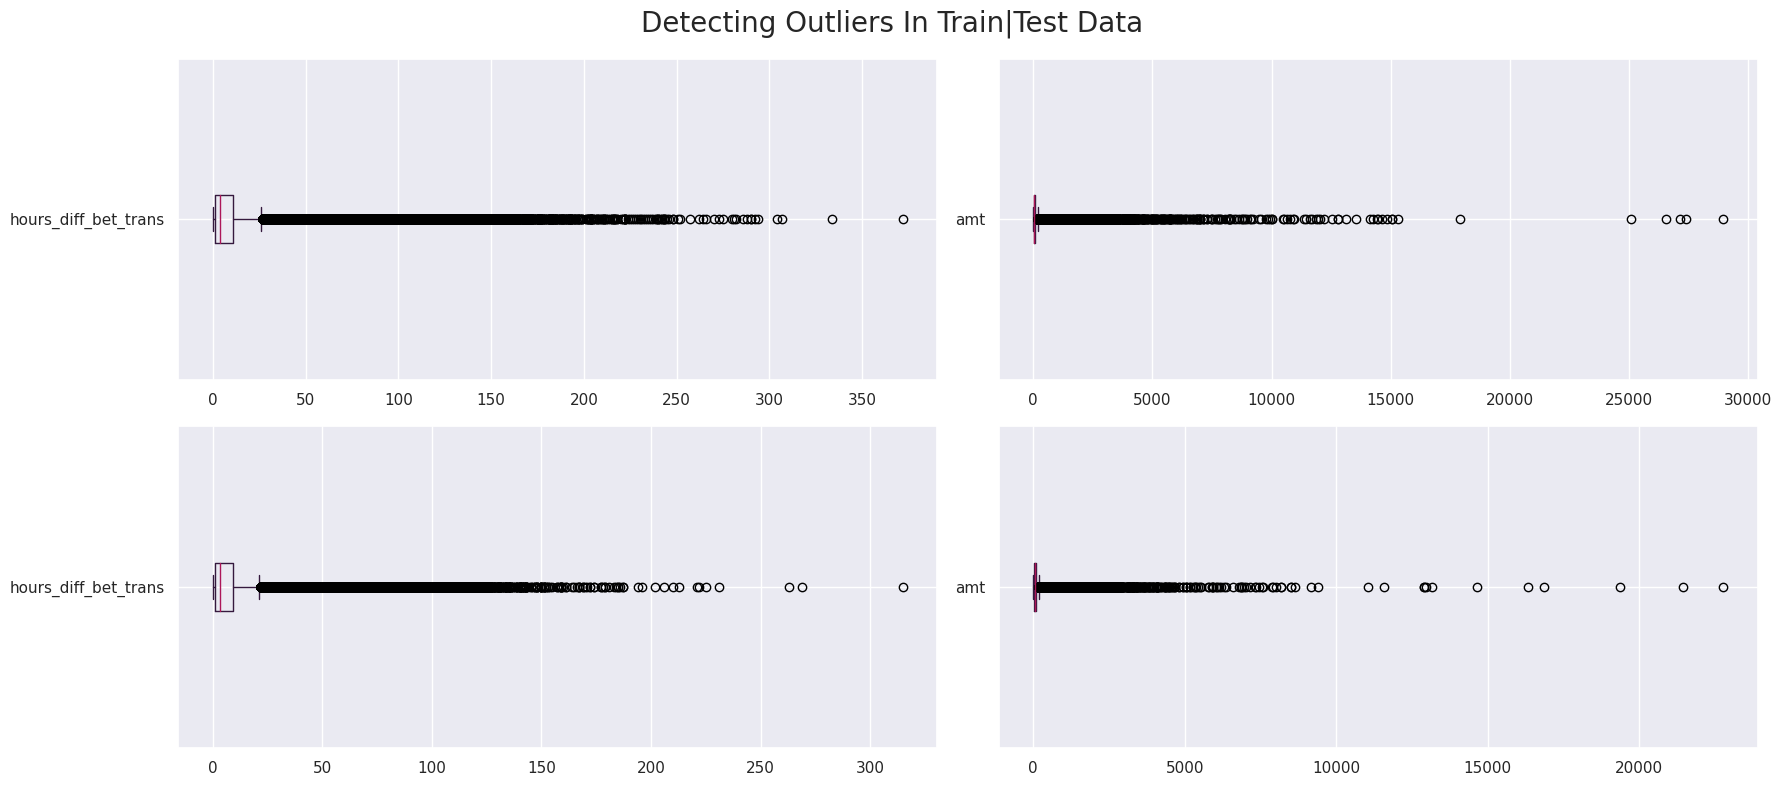

In [ ]:
count_outliers(cols)
boxplot_outliers(datasets)

In [ ]:
#Applying log scale
#Need to explain why apply log scale to the outliers?
for col in cols:
    x_train[col] = np.log1p(x_train[col])
    x_test[col] = np.log1p(x_test[col])

Outliers In hours_diff_bet_trans: 222
Outliers In amt: 818


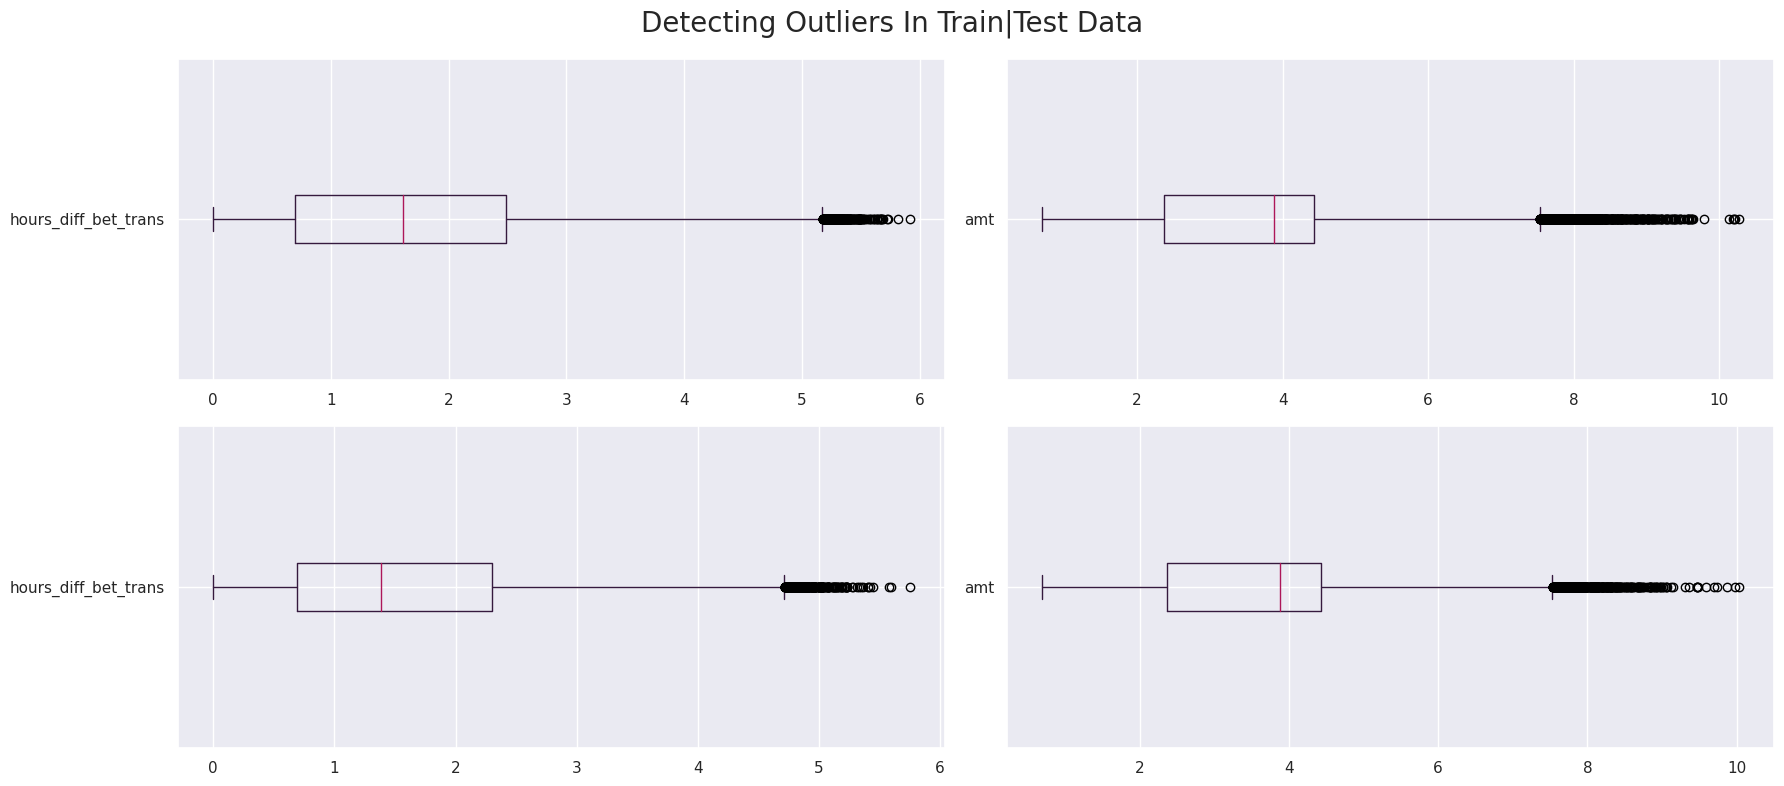

In [ ]:
count_outliers(cols)
boxplot_outliers(datasets)

As we can see the log transformation make the distribution more symmetric and reduce the impact of extreme values(We did not removed them).Also we can deal with these data separately,But for now: log functions are commonly used to handle right-skewed distributions. After applying our model we can revert data with exp. function to recover the actual data.

In [ ]:
#Note:-
#Logistic Regression often benefits from feature scaling.Since the algorithm uses the weights assigned to features during
#training, and having features on similar scales can help the optimization process converge faster.
#While Decision Trees, including Random Forest (an ensemble of decision trees), are generally not sensitive to the scale of the
#features.They make decisions based on splitting criteria and don't rely on the absolute values of the features.
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
evl_models = {'Decision Tree':DecisionTreeClassifier(random_state=10)}

In [ ]:
def evl_model(xtrain,ytrain,xtest,ytest):
    sns.set(rc={'figure.figsize':(18,6)})
    i=0
    for name,model in evl_models.items():
        fig,axs=plt.subplots(1,2)
        print('Model : '+name)
        print('_'*30)
        start=time()
        model.fit(xtrain,ytrain)
        y_pred = model.predict(xtest)
        end=time()
        #Confusion Matrix
        cm = confusion_matrix(ytest,y_pred,labels=model.classes_)
        cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        cmd.plot(colorbar=False,ax=axs[i])
        axs[i].grid(False)
        #AUC-ROC Curve
        y_proba = model.predict_proba(xtest)
        fpr, tpr, _ = roc_curve(ytest, y_proba[:, 1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[i+1])
        axs[i+1].plot([0, 1], [0, 1], color = 'g')
        plt.tight_layout()
        plt.show()
        #We focus on recall=TP/TP+FN
        #such that it's the score that model predict(non-fraud) while it's fraud.
        print('Recall Score: ',recall_score(ytest,y_pred))
        print('Precision: ',precision_score(ytest,y_pred))
        print('F1-Score: ',f1_score(ytest,y_pred))
        print('Accuracy Score: ',accuracy_score(ytest,y_pred))
        print('AUC Score: ',roc_auc_score(ytest,y_proba[:,1]))
        print('Running Time : ',round((end-start)/60.0,2),'Mins')
        print('*'*30)

Model : Decision Tree
______________________________


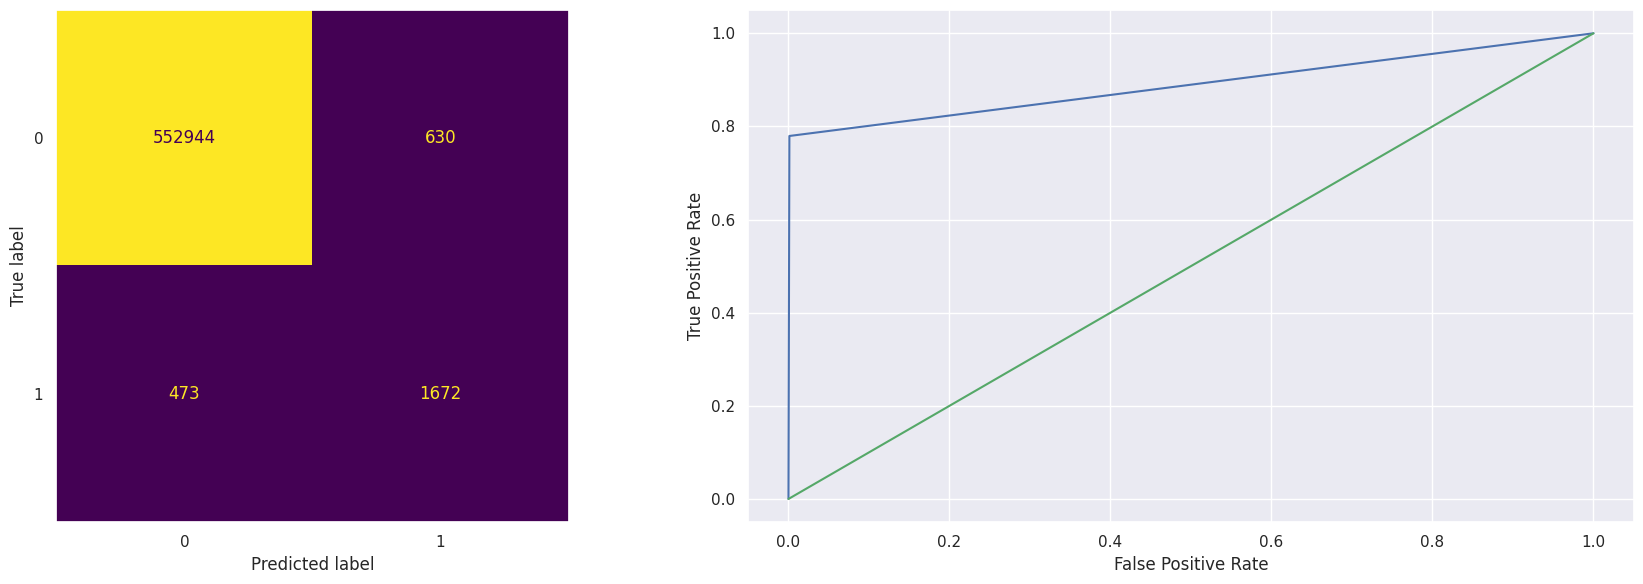

Recall Score:  0.7794871794871795
Precision:  0.7263249348392702
F1-Score:  0.7519676186192938
Accuracy Score:  0.9980151839328869
AUC Score:  0.8891745601287595
Running Time :  0.31 Mins
******************************


In [ ]:
evl_model(x_train,y_train,x_test,y_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Create your existing Random Forest model
clf = DecisionTreeClassifier(max_depth = 30, random_state=10)

# Extract features and target variable
x_train = df.drop(['is_fraud', 'split'], axis=1)  # Assuming 'is_fraud' is your target variable
y_train = df['is_fraud']

# Fit the model on the oversampled training data
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=30, random_state=10)

In [ ]:
#Let's apply SMOTE over sampling to make balance between fraud and non-fraud data and see if there is a significant different
#Between the accuracies or not
smote = SMOTE()
x_train,y_train = smote.fit_resample(x_train,y_train)

<Axes: ylabel='is_fraud'>

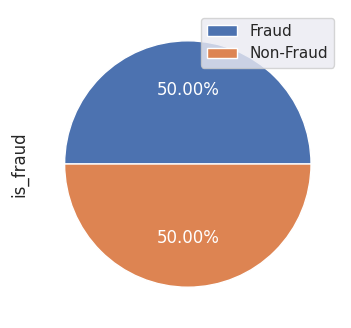

In [ ]:
y_train.value_counts().plot(kind='pie',figsize=(4,4),autopct='%.2f%%',textprops={'color':'white'},labels=['Fraud','Non-Fraud'],legend=True)

Model : Decision Tree
______________________________


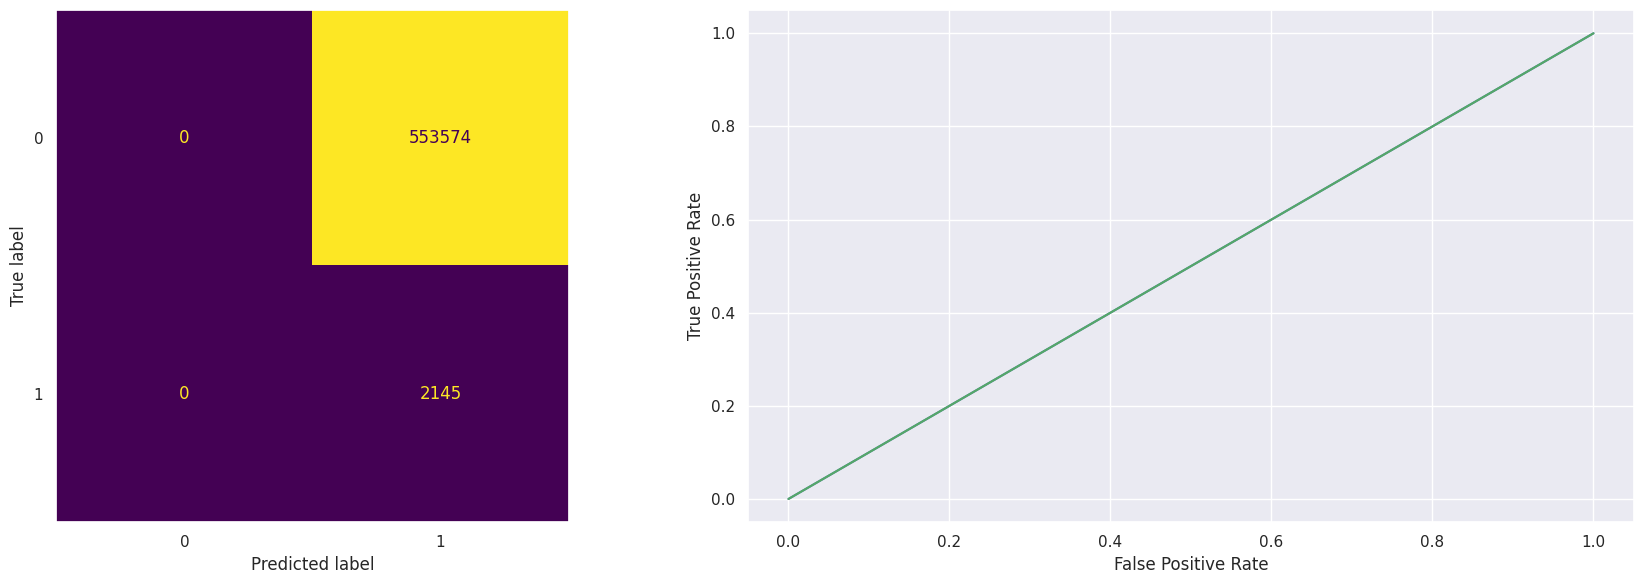

Recall Score:  1.0
Precision:  0.0038598644278853163
F1-Score:  0.007690046319533076
Accuracy Score:  0.0038598644278853163
AUC Score:  0.5
Running Time :  1.89 Mins
******************************


In [ ]:
evl_model(x_train,y_train,x_test,y_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Create your existing Random Forest model
clf = DecisionTreeClassifier()

# Extract features and target variable
x_train = df.drop(['is_fraud', 'split'], axis=1)  # Assuming 'is_fraud' is your target variable
y_train = df['is_fraud']

# Fit the model on the oversampled training data
clf.fit(x_train, y_train)

DecisionTreeClassifier()

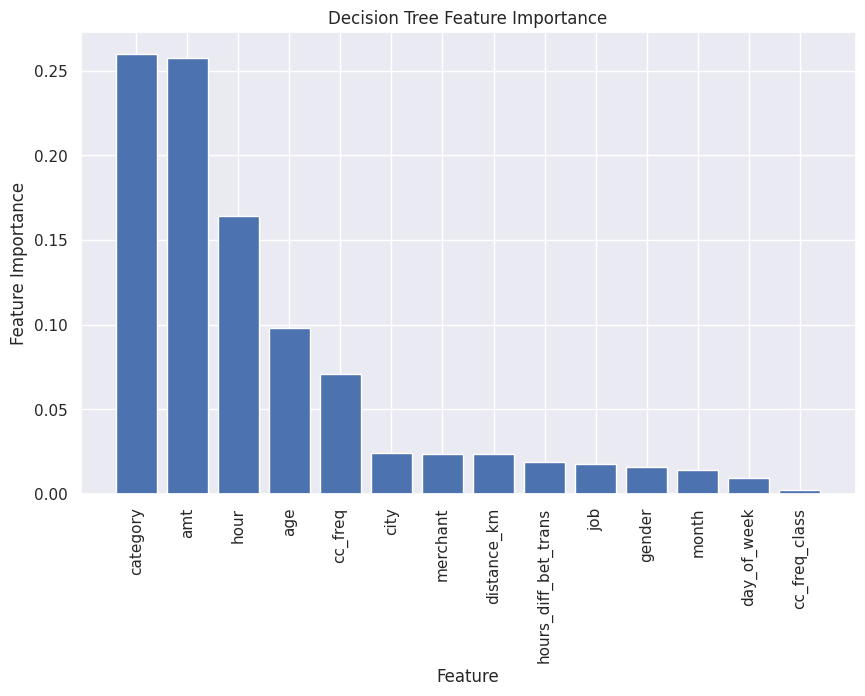

In [ ]:
# Get feature importances
feature_importances = clf.feature_importances_

# Get the names of features
feature_names = x_train.columns

# Sort features based on their importance
sorted_idx = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), feature_names[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()

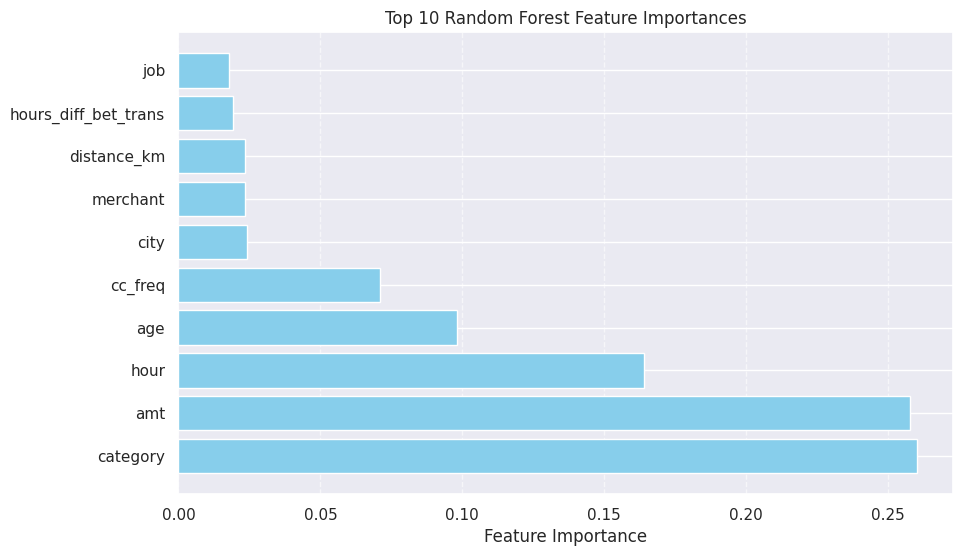

In [ ]:
# Set the number of top features to display
top_n = 10

# Get feature importances
feature_importances = clf.feature_importances_

# Get the names of features
feature_names = x_train.columns

# Sort features based on their importance
sorted_idx = feature_importances.argsort()[::-1]

# Only keep the top N features
top_idx = sorted_idx[:top_n]
top_features = feature_names[top_idx]
top_importances = feature_importances[top_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_importances, align="center", color='skyblue')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Random Forest Feature Importances")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

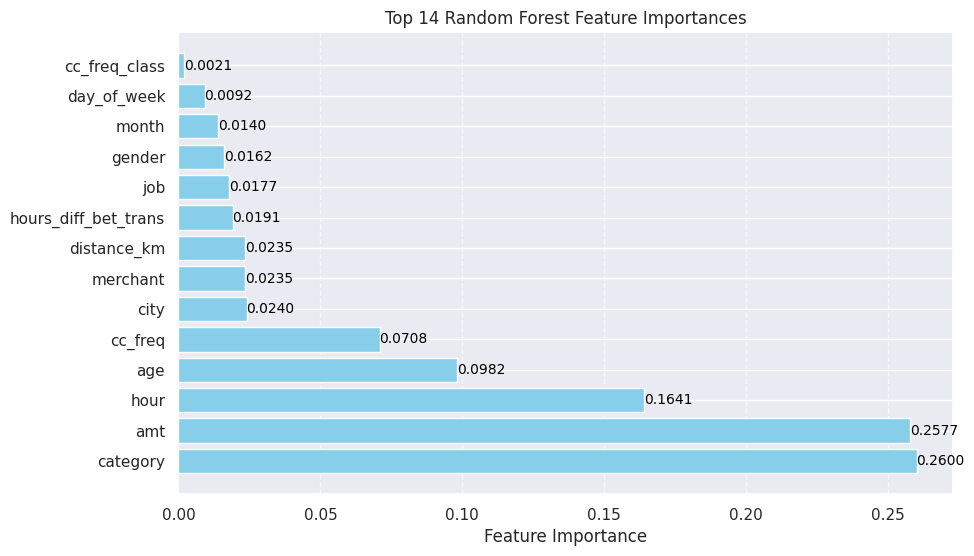

In [ ]:
import matplotlib.pyplot as plt

# Set the number of top features to display
top_n = 14

# Get feature importances
feature_importances = clf.feature_importances_

# Get the names of features
feature_names = x_train.columns

# Sort features based on their importance
sorted_idx = feature_importances.argsort()[::-1]

# Only keep the top N features
top_idx = sorted_idx[:top_n]
top_features = feature_names[top_idx]
top_importances = feature_importances[top_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(top_features)), top_importances, color='skyblue')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Random Forest Feature Importances")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add annotations for exact numeric values
for bar, importance in zip(bars, top_importances):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{importance:.4f}',
             va='center', ha='left', fontsize=10, color='black')

plt.show()
